In [4]:
!python -V

Python 3.9.19


In [5]:
import pandas as pd

In [6]:
import pickle

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [9]:
import mlflow

# Set the tracking uri, we need this because we are running mlflow with the sqlite backend
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Set the experiment, if it doesn't exist mlflow will create it
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/ubuntu/my_repo/mlops_course_repo/02-experiment-tracking/mlruns/1', creation_time=1717429847024, experiment_id='1', last_update_time=1717429847024, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [10]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [11]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829628

/tmp/ipykernel_4036/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')


/tmp/ipykernel_4036/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


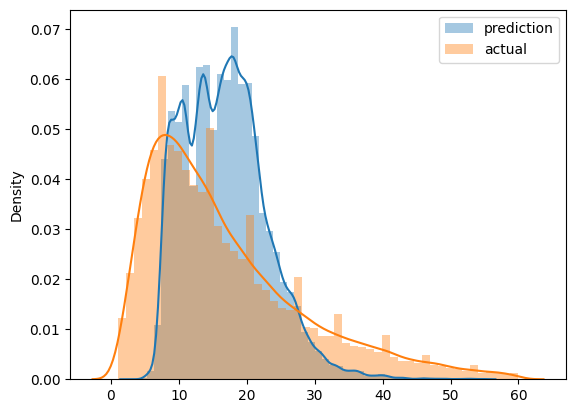

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [13]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [14]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [15]:
len(df_train), len(df_val)

(73908, 61921)

In [16]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [17]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [18]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715200888857

In [20]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


11.167275941179728

In [22]:
# I just trained 2 models but I have no tracking of this
# In order to having tracking of the different experiments (train the model with different parameters, features, etc) we do next:

with mlflow.start_run():
    # Logging information about this run:
    mlflow.set_tag("developer", "coni")  # the name of the developer could be a good idea if I work in a big team   
                                         # then based on this tag I can filter the run
    
    # Logging information about the dataset:
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")   
    # Param includes hyperparameters of the model but also any extra information I consider important, 
    # for example which dataset I use for training and which for testing
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
    
    alpha = 0.1
    # I can also log the parameter alpha
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    # Log of performance metric:
    mlflow.log_metric("rmse", rmse)

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Trying XGBoost

In [1]:
import xgboost as xgb


In [2]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

# Hyperopt is a powerful tool for tuning ML models with Apache Spark.

In [23]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

**Note:** XGBoost uses a data type called dense matrix for efficient training and prediction (optimized for both memory efficiency and training speed”), thus we created DMatrix object for our training and validation datasets. We could also use a wraper (XGBClassifier() or XGBRegressor()) and then use scikit-learn methods such as .train_test_split() or .fit(), this methods take as inputs pandas dataframes or numpy arrays. The Scikit API is just a wrapper over the xgb.train and under the hood, it converts the data to Dmatrix.

In [24]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

**Hyoeropt hp.uniform versus hp.loguniform**\
Hyperopt offers hp.uniform and hp.loguniform, both of which produce real values in a min/max range. hp.loguniform is more suitable when one might choose a **geometric** series of values to try (0.001, 0.01, 0.1) rather than arithmetic (0.1, 0.2, 0.3). Which one is more suitable depends on the context, and typically does not make a large difference, but is worth considering.

hp.choice\
hp.quniform (“quantized uniform”) or hp.qloguniform are well suited to generate integers. hp.choice is the right choice when, for example, choosing among categorical choices (which might in some situations even be integers, but not usually).


In [25]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)), # params: (label, low, high, q) returns --> round(uniform(low, high)/q)*q
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # the interval will be exp(-3), exp(0) - [~0.05 - 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear', #regression problem 
    'seed': 42
}

# We use fmin() to execute a Hyperopt run
# fn argument --> is the Objective function. Hyperopt calls this function with values generated from 
# the hyperparameter space provided in the space argument. This function can return the loss as 
# a scalar value or in a dictionary. This function typically contains code for model training and loss calculation.
# algo --> Hyperopt search algorithm to use to search hyperparameter space. Most commonly used are
# hyperopt.rand.suggest for Random Search and hyperopt.tpe.suggest for TPE (tree-structured parzen estimator)
# max_evals --> nbr of hyperparameter settings to try (nbr of models to fit)
# trials --> We use Trials when we call distributed training algorithms 
# early_stop_fn --> An optional early stopping function to determine if fmin should stop before max_evals is reached. 
# Default is None.
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:11:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.49703                          
[1]	validation-rmse:10.86559                          
[2]	validation-rmse:10.31104                          
[3]	validation-rmse:9.82556                           
[4]	validation-rmse:9.40171                           
[5]	validation-rmse:9.03309                           
[6]	validation-rmse:8.71367                           
[7]	validation-rmse:8.43715                           
[8]	validation-rmse:8.19879                           
[9]	validation-rmse:7.99405                           
[10]	validation-rmse:7.81741                          
[11]	validation-rmse:7.66627                          
[12]	validation-rmse:7.53697                          
[13]	validation-rmse:7.42599                          
[14]	validation-rmse:7.33102                          
[15]	validation-rmse:7.24991                          
[16]	validation-rmse:7.18014                          
[17]	validation-rmse:7.11995                          
[18]	valid

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:13:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.32840                                                     
[1]	validation-rmse:10.56945                                                     
[2]	validation-rmse:9.92246                                                      
[3]	validation-rmse:9.37230                                                      
[4]	validation-rmse:8.90810                                                      
[5]	validation-rmse:8.51665                                                      
[6]	validation-rmse:8.18828                                                      
[7]	validation-rmse:7.91460                                                      
[8]	validation-rmse:7.68728                                                      
[9]	validation-rmse:7.49774                                                      
[10]	validation-rmse:7.33981                                                     
[11]	validation-rmse:7.20990                                                     
[12]	validation-

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:14:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.93838                                                     
[1]	validation-rmse:6.66501                                                     
[2]	validation-rmse:6.63725                                                     
[3]	validation-rmse:6.62952                                                     
[4]	validation-rmse:6.61887                                                     
[5]	validation-rmse:6.61392                                                     
[6]	validation-rmse:6.60931                                                     
[7]	validation-rmse:6.59892                                                     
[8]	validation-rmse:6.59480                                                     
[9]	validation-rmse:6.59107                                                     
[10]	validation-rmse:6.58782                                                    
[11]	validation-rmse:6.57967                                                    
[12]	validation-rmse:6.56826

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:15:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.36684                                                  
[1]	validation-rmse:10.63654                                                  
[2]	validation-rmse:10.01102                                                  
[3]	validation-rmse:9.47624                                                   
[4]	validation-rmse:9.02036                                                   
[5]	validation-rmse:8.63397                                                   
[6]	validation-rmse:8.30206                                                   
[7]	validation-rmse:8.02677                                                   
[8]	validation-rmse:7.79682                                                   
[9]	validation-rmse:7.59979                                                   
[10]	validation-rmse:7.44361                                                  
[11]	validation-rmse:7.30543                                                  
[12]	validation-rmse:7.19688                        

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:17:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.91905                                                     
[1]	validation-rmse:6.72349                                                     
[2]	validation-rmse:6.70973                                                     
[3]	validation-rmse:6.69961                                                     
[4]	validation-rmse:6.69533                                                     
[5]	validation-rmse:6.68621                                                     
[6]	validation-rmse:6.68670                                                     
[7]	validation-rmse:6.68592                                                     
[8]	validation-rmse:6.67989                                                     
[9]	validation-rmse:6.67577                                                     
[10]	validation-rmse:6.67259                                                    
[11]	validation-rmse:6.66701                                                    
[12]	validation-rmse:6.66330

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:17:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.65954                                                  
[1]	validation-rmse:11.15460                                                  
[2]	validation-rmse:10.69346                                                  
[3]	validation-rmse:10.27487                                                  
[4]	validation-rmse:9.89450                                                   
[5]	validation-rmse:9.54810                                                   
[6]	validation-rmse:9.23572                                                   
[7]	validation-rmse:8.95378                                                   
[8]	validation-rmse:8.69893                                                   
[9]	validation-rmse:8.46824                                                   
[10]	validation-rmse:8.26229                                                  
[11]	validation-rmse:8.07828                                                  
[12]	validation-rmse:7.91158                        

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:20:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.00824                                                       
[1]	validation-rmse:7.64180                                                       
[2]	validation-rmse:7.09595                                                       
[3]	validation-rmse:6.87986                                                       
[4]	validation-rmse:6.78222                                                       
[5]	validation-rmse:6.73546                                                       
[6]	validation-rmse:6.71374                                                       
[7]	validation-rmse:6.69308                                                       
[8]	validation-rmse:6.68346                                                       
[9]	validation-rmse:6.67839                                                       
[10]	validation-rmse:6.67532                                                      
[11]	validation-rmse:6.67344                                                      
[12]

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:21:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.02903                                                      
[1]	validation-rmse:6.73018                                                      
[2]	validation-rmse:6.66963                                                      
[3]	validation-rmse:6.63991                                                      
[4]	validation-rmse:6.62942                                                      
[5]	validation-rmse:6.62712                                                      
[6]	validation-rmse:6.62174                                                      
[7]	validation-rmse:6.61673                                                      
[8]	validation-rmse:6.61327                                                      
[9]	validation-rmse:6.61354                                                      
[10]	validation-rmse:6.60852                                                     
[11]	validation-rmse:6.60621                                                     
[12]	validation-

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:22:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.18163                                                    
[1]	validation-rmse:7.72012                                                    
[2]	validation-rmse:7.05697                                                    
[3]	validation-rmse:6.76679                                                    
[4]	validation-rmse:6.62260                                                    
[5]	validation-rmse:6.55022                                                    
[6]	validation-rmse:6.50869                                                    
[7]	validation-rmse:6.48125                                                    
[8]	validation-rmse:6.46623                                                    
[9]	validation-rmse:6.45330                                                    
[10]	validation-rmse:6.44036                                                   
[11]	validation-rmse:6.43481                                                   
[12]	validation-rmse:6.42969            

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:22:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.37068                                                    
[1]	validation-rmse:6.77263                                                    
[2]	validation-rmse:6.67082                                                    
[3]	validation-rmse:6.64322                                                    
[4]	validation-rmse:6.63675                                                    
[5]	validation-rmse:6.63009                                                    
[6]	validation-rmse:6.61749                                                    
[7]	validation-rmse:6.61099                                                    
[8]	validation-rmse:6.60704                                                    
[9]	validation-rmse:6.59986                                                    
[10]	validation-rmse:6.59513                                                   
[11]	validation-rmse:6.58842                                                   
[12]	validation-rmse:6.58183            

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:23:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69151                                                    
[1]	validation-rmse:11.21308                                                    
[2]	validation-rmse:10.77478                                                    
[3]	validation-rmse:10.37376                                                    
[4]	validation-rmse:10.00773                                                    
[5]	validation-rmse:9.67422                                                     
[6]	validation-rmse:9.37052                                                     
[7]	validation-rmse:9.09443                                                     
[8]	validation-rmse:8.84371                                                     
[9]	validation-rmse:8.61652                                                     
[10]	validation-rmse:8.41070                                                    
[11]	validation-rmse:8.22486                                                    
[12]	validation-rmse:8.05648

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:26:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.27752                                                    
[1]	validation-rmse:10.48786                                                    
[2]	validation-rmse:9.82119                                                     
[3]	validation-rmse:9.26046                                                     
[4]	validation-rmse:8.79768                                                     
[5]	validation-rmse:8.40289                                                     
[6]	validation-rmse:8.08449                                                     
[7]	validation-rmse:7.81786                                                     
[8]	validation-rmse:7.59893                                                     
[9]	validation-rmse:7.42057                                                     
[10]	validation-rmse:7.27657                                                    
[11]	validation-rmse:7.15642                                                    
[12]	validation-rmse:7.05489

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:27:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.30884                                                    
[1]	validation-rmse:9.01832                                                     
[2]	validation-rmse:8.16622                                                     
[3]	validation-rmse:7.61476                                                     
[4]	validation-rmse:7.26418                                                     
[5]	validation-rmse:7.04184                                                     
[6]	validation-rmse:6.89165                                                     
[7]	validation-rmse:6.79400                                                     
[8]	validation-rmse:6.72893                                                     
[9]	validation-rmse:6.68286                                                     
[10]	validation-rmse:6.65215                                                    
[11]	validation-rmse:6.62839                                                    
[12]	validation-rmse:6.61264

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:29:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.98533                                                    
[1]	validation-rmse:10.00971                                                    
[2]	validation-rmse:9.24456                                                     
[3]	validation-rmse:8.64916                                                     
[4]	validation-rmse:8.18945                                                     
[5]	validation-rmse:7.83523                                                     
[6]	validation-rmse:7.56569                                                     
[7]	validation-rmse:7.35948                                                     
[8]	validation-rmse:7.20476                                                     
[9]	validation-rmse:7.08734                                                     
[10]	validation-rmse:6.99717                                                    
[11]	validation-rmse:6.92804                                                    
[12]	validation-rmse:6.87404

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:30:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.82165                                                    
[1]	validation-rmse:9.74797                                                     
[2]	validation-rmse:8.93051                                                     
[3]	validation-rmse:8.31535                                                     
[4]	validation-rmse:7.85736                                                     
[5]	validation-rmse:7.51930                                                     
[6]	validation-rmse:7.27063                                                     
[7]	validation-rmse:7.08986                                                     
[8]	validation-rmse:6.95587                                                     
[9]	validation-rmse:6.85715                                                     
[10]	validation-rmse:6.78179                                                    
[11]	validation-rmse:6.72633                                                    
[12]	validation-rmse:6.68389

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:31:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.74827                                                     
[1]	validation-rmse:6.63418                                                     
[2]	validation-rmse:6.61235                                                     
[3]	validation-rmse:6.60188                                                     
[4]	validation-rmse:6.57738                                                     
[5]	validation-rmse:6.56690                                                     
[6]	validation-rmse:6.56229                                                     
[7]	validation-rmse:6.55617                                                     
[8]	validation-rmse:6.55203                                                     
[9]	validation-rmse:6.54660                                                     
[10]	validation-rmse:6.54461                                                    
[11]	validation-rmse:6.54383                                                    
[12]	validation-rmse:6.54217

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:32:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.81117                                                     
[3]	validation-rmse:6.80150                                                     
[4]	validation-rmse:6.79283                                                     
[5]	validation-rmse:6.78180                                                     
[6]	validation-rmse:6.77796                                                     
[7]	validation-rmse:6.77377                                                     
[8]	validation-rmse:6.77192                                                     
[9]	validation-rmse:6.76545                                                     
[10]	validation-rmse:6.76268                                                    
[11]	validation-rmse:6.75750                                                    
[12]	validation-rmse:6.75114                                                    
[13]	validation-rmse:6.74818                                                    
[14]	validation-rmse:6.74175

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:32:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.62325                                                    
[1]	validation-rmse:11.09037                                                    
[2]	validation-rmse:10.60977                                                    
[3]	validation-rmse:10.17735                                                    
[4]	validation-rmse:9.78883                                                     
[5]	validation-rmse:9.44103                                                     
[6]	validation-rmse:9.13017                                                     
[7]	validation-rmse:8.85316                                                     
[8]	validation-rmse:8.60622                                                     
[9]	validation-rmse:8.38668                                                     
[10]	validation-rmse:8.19222                                                    
[11]	validation-rmse:8.01995                                                    
[12]	validation-rmse:7.86712

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:35:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.76100                                                     
[1]	validation-rmse:8.36072                                                     
[2]	validation-rmse:7.59974                                                     
[3]	validation-rmse:7.19278                                                     
[4]	validation-rmse:6.97853                                                     
[5]	validation-rmse:6.85840                                                     
[6]	validation-rmse:6.78765                                                     
[7]	validation-rmse:6.74748                                                     
[8]	validation-rmse:6.72184                                                     
[9]	validation-rmse:6.70444                                                     
[10]	validation-rmse:6.69366                                                    
[11]	validation-rmse:6.67982                                                    
[12]	validation-rmse:6.67149

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:36:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.83574                                                     
[1]	validation-rmse:6.70706                                                     
[2]	validation-rmse:6.68441                                                     
[3]	validation-rmse:6.67818                                                     
[4]	validation-rmse:6.66956                                                     
[5]	validation-rmse:6.66434                                                     
[6]	validation-rmse:6.66112                                                     
[7]	validation-rmse:6.65964                                                     
[8]	validation-rmse:6.65732                                                     
[9]	validation-rmse:6.65567                                                     
[10]	validation-rmse:6.65425                                                    
[11]	validation-rmse:6.65388                                                    
[12]	validation-rmse:6.65051

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:36:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.75476                                                    
[1]	validation-rmse:11.32971                                                    
[2]	validation-rmse:10.93545                                                    
[3]	validation-rmse:10.57157                                                    
[4]	validation-rmse:10.23520                                                    
[5]	validation-rmse:9.92456                                                     
[6]	validation-rmse:9.63806                                                     
[7]	validation-rmse:9.37403                                                     
[8]	validation-rmse:9.13123                                                     
[9]	validation-rmse:8.90863                                                     
[10]	validation-rmse:8.70415                                                    
[11]	validation-rmse:8.51709                                                    
[12]	validation-rmse:8.34647

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:39:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79717                                                    
[1]	validation-rmse:11.40786                                                    
[2]	validation-rmse:11.04378                                                    
[3]	validation-rmse:10.70445                                                    
[4]	validation-rmse:10.38769                                                    
[5]	validation-rmse:10.09301                                                    
[6]	validation-rmse:9.81950                                                     
[7]	validation-rmse:9.56426                                                     
[8]	validation-rmse:9.32705                                                     
[9]	validation-rmse:9.10759                                                     
[10]	validation-rmse:8.90430                                                    
[11]	validation-rmse:8.71498                                                    
[12]	validation-rmse:8.53942

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:42:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.78867                                                     
[1]	validation-rmse:11.39190                                                     
[2]	validation-rmse:11.02217                                                     
[3]	validation-rmse:10.67761                                                     
[4]	validation-rmse:10.35686                                                     
[5]	validation-rmse:10.05867                                                     
[6]	validation-rmse:9.78145                                                      
[7]	validation-rmse:9.52451                                                      
[8]	validation-rmse:9.28584                                                      
[9]	validation-rmse:9.06473                                                      
[10]	validation-rmse:8.86041                                                     
[11]	validation-rmse:8.67149                                                     
[12]	validation-

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:46:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.58879                                                       
[1]	validation-rmse:11.02898                                                       
[2]	validation-rmse:10.52776                                                       
[3]	validation-rmse:10.07676                                                       
[4]	validation-rmse:9.67920                                                        
[5]	validation-rmse:9.32050                                                        
[6]	validation-rmse:9.00112                                                        
[7]	validation-rmse:8.71601                                                        
[8]	validation-rmse:8.46475                                                        
[9]	validation-rmse:8.24050                                                        
[10]	validation-rmse:8.04784                                                       
[11]	validation-rmse:7.87199                                                

KeyboardInterrupt: 

We stopped the previous cell cause it was taking too much time, and we took the best parameters so far from mlflow (the ones with the lowest rmse).

In [26]:
# Next copied and pasted from MLflow interface
params = {
    'learning_rate': 0.2137120765629681,
    'max_depth': 43,
    'min_child_weight': 1.2520399262735529,
    'objective': 'reg:linear',
    'reg_alpha': 0.0070284244487043715,
    'reg_lambda': 0.31934100898920603,
    'seed': 42   
}
# Save the model and log the training into mlflow
# One way to do so would be using "with" clause and then adding mlflow.set_tag(), mlflow.log_param(), etc
# but we can do this in other way but it works just with certain frameworks:
# https://mlflow.org/docs/latest/tracking/autolog.html
# Maybe we will need to add aditional logs but this will help us to reduce time

# enable autolog for xgboost
mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2024/06/03 20:01:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '94fc57ebd86642bb868ea54ad104db06', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:01:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.52074
[1]	validation-rmse:9.30102
[2]	validation-rmse:8.43958
[3]	validation-rmse:7.84202
[4]	validation-rmse:7.43525
[5]	validation-rmse:7.15515
[6]	validation-rmse:6.96226
[7]	validation-rmse:6.83027
[8]	validation-rmse:6.73739
[9]	validation-rmse:6.67085
[10]	validation-rmse:6.62436
[11]	validation-rmse:6.58754
[12]	validation-rmse:6.55996
[13]	validation-rmse:6.53915
[14]	validation-rmse:6.52250
[15]	validation-rmse:6.50994
[16]	validation-rmse:6.50126
[17]	validation-rmse:6.49320
[18]	validation-rmse:6.48683
[19]	validation-rmse:6.48194
[20]	validation-rmse:6.47712
[21]	validation-rmse:6.47456
[22]	validation-rmse:6.47251
[23]	validation-rmse:6.47162
[24]	validation-rmse:6.46998
[25]	validation-rmse:6.46683
[26]	validation-rmse:6.46469
[27]	validation-rmse:6.46248
[28]	validation-rmse:6.46033
[29]	validation-rmse:6.45828
[30]	validation-rmse:6.45584
[31]	validation-rmse:6.45451
[32]	validation-rmse:6.45253
[33]	validation-rmse:6.45051
[34]	validation-rmse:6.

2024/06/03 20:03:23 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/06/03 20:03:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:03:23] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
